<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

"nvidia-smi" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code


2.2.0+cpu


## 1. What are 3 areas in industry where computer vision is currently being used?

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
train_data = MNIST(root='data',
                   download=True,
                   transform=ToTensor(),
                   train=True)

In [4]:
test_data = MNIST(root='data',
                   download=True,
                   transform=ToTensor(),
                   train=False)

In [5]:


len(train_data), len(test_data)
     


(60000, 10000)

In [6]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

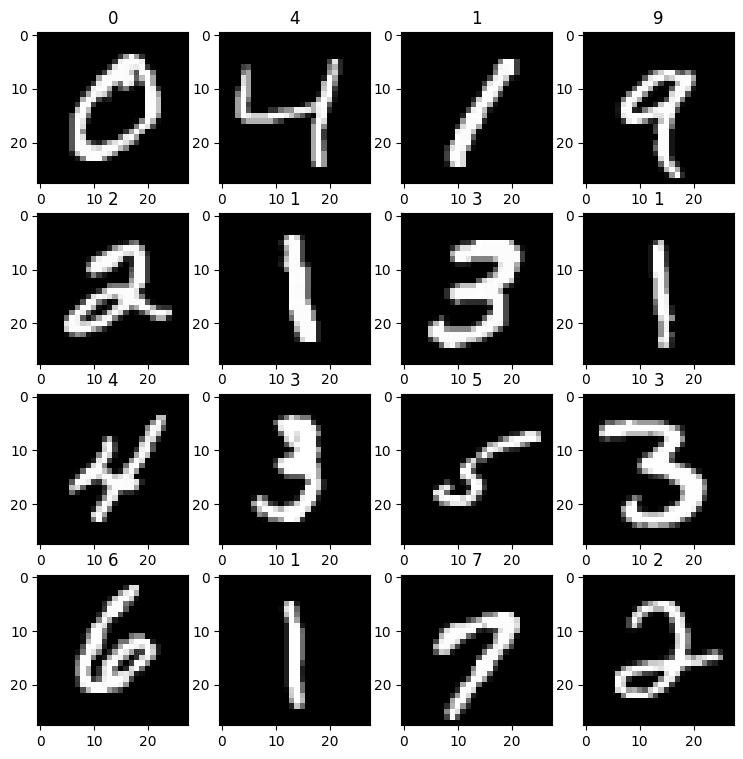

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, 1 + rows * cols):
    fig.add_subplot(rows, cols, i)
    image, label = train_data[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [8]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(dataset=train_data,
                               batch_size=32,
                               shuffle=True,
                               )
test_data_loader = DataLoader(dataset=test_data,
                               batch_size=32,
                               shuffle=False,
                               )

In [9]:
len(train_data_loader), len(test_data_loader)

(1875, 313)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [10]:
from torch import nn

class MNISTClassificationv2(nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.first_stack = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=10,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.second_stack = nn.Sequential(
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Flatten(),
            nn.Linear(in_features=160, out_features=10)
        )

    def forward(self, x):
        x = self.first_stack(x)
        #print(x.shape)
        x = self.second_stack(x)
        x = self.classifier(x)
        return(x)


In [11]:
model_2 = MNISTClassificationv2()
model_2(next(iter(train_data_loader))[0][0].unsqueeze(dim=0)).shape

torch.Size([1, 10])

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [12]:
import torch.utils


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [13]:
from helper_functions import accuracy_fn
epochs = 5

for epoch in range(epochs):
    train_loss, train_acc = 0, 0
    model_2.train()

    for X, y in train_data_loader:
        y_logits = model_2(X)
        train_loss_batch = loss_fn(y_logits, y)

        optimizer.zero_grad()
        train_loss_batch.backward()
        optimizer.step()

        train_loss += train_loss_batch
        train_acc_batch = accuracy_fn(y_true=y, y_pred=y_logits.argmax(dim=1))
        train_acc += train_acc_batch
    
    train_loss /= len(train_data_loader)
    train_acc /= len(train_data_loader)

    test_loss, test_acc = 0, 0
    model_2.eval()
    with torch.no_grad():
        for X, y in test_data_loader:
            y_logits = model_2(X)
            test_loss_batch = loss_fn(y_logits, y)
            test_loss += test_loss_batch
            test_acc_batch = accuracy_fn(y_true=y, y_pred=y_logits.argmax(dim=1))
            test_acc += test_acc_batch

        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")





Train loss: 0.23972 | Train accuracy: 92.17%
Test loss: 0.08095 | Test accuracy: 97.57%
Train loss: 0.07794 | Train accuracy: 97.56%
Test loss: 0.05383 | Test accuracy: 98.12%
Train loss: 0.06014 | Train accuracy: 98.17%
Test loss: 0.04973 | Test accuracy: 98.43%
Train loss: 0.05212 | Train accuracy: 98.36%
Test loss: 0.04467 | Test accuracy: 98.65%


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?